<a href="https://colab.research.google.com/github/MMWa/Image-Search/blob/master/Search_using_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [0]:
def create_layers():
  layers = []
  size = 32
  depth = 3
  
  #encoder layers
  for i in range(0, depth):
    x = tf.layers.Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x] 
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
    layers += [x]
    size = size // 2
  

  #deocder layers 
  for i in range(0, depth):
    size = size * 2
    if i == 2:
      x = tf.layers.Conv2D(size, (3, 3), activation='relu')
    else:
      x = tf.layers.Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x]
    x = tf.keras.layers.UpSampling2D((2, 2))
    layers += [x]
    
    
  x = tf.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
  layers += [x]
  
  return layers

def create_autoencoder():
  input_img = tf.keras.layers.Input(shape=(28, 28, 1))  

  layers = create_layers()

  #create the auto encoder network 
  x = input_img
  for layer in layers:
    x = layer(x)
    
  autoencoder = tf.keras.Model(input_img, x)
  autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  
  #create the encoder network
  x = input_img
  for layer in layers[0:6]:
    x = layer(x)
    
  encoder = tf.keras.Model(input_img, x)
  print(x.shape)
  
  
  #create the decoder network
  input_encoded = tf.keras.layers.Input(shape = x.shape[1:4])
  x = input_encoded
  for layer in layers[6:]:
    x = layer(x)

  decoder = tf.keras.Model(input_encoded, x)
  return autoencoder, encoder, decoder

In [0]:
autoencoder, encoder, decoder = create_autoencoder()
autoencoder.summary()
encoder.summary()
decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
(?, 4, 4, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_test = x_test/255

x_test = x_test

print(x_train.shape)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_train.reshape((-1, 28, 28, 1))

print(x_train.shape)


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

autoencoder.fit(x_train, x_train,
          batch_size=2048,
          epochs=20,
          verbose=1,
          validation_data=(x_test, x_test),
          callbacks= [es])

Train on 60000 samples, validate on 60000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
60000/60000 [==============================] - 9s 158us/sample - loss: 1005.7260 - acc: 0.8073 - val_loss: 722.5092 - val_acc: 0.8088
Epoch 2/20
60000/60000 [==============================] - 6s 96us/sample - loss: 569.0960 - acc: 0.8088 - val_loss: 460.4958 - val_acc: 0.8062
Epoch 3/20
60000/60000 [==============================] - 6s 96us/sample - loss: 425.0027 - acc: 0.7861 - val_loss: 395.6896 - val_acc: 0.7866
Epoch 4/20
60000/60000 [==============================] - 6s 96us/sample - loss: 377.6046 - acc: 0.7897 - val_loss: 358.0561 - val_acc: 0.7929
Epoch 5/20
60000/60000 [==============================] - 6s 95us/sample - loss: 345.2246 - acc: 0.7948 - val_loss: 332.9332 - val_acc: 0.7970
Epoch 6/20
60000/60000 [==============================] - 6s 95us/sample - loss: 324.8838 - acc: 0.7977 - val_loss: 317.7196 - val_acc: 0.8007
Epoch 7/20
60000/60000 [==================

In [0]:
import random
test_sample = random.choice(x_test)

query_sample = test_sample.reshape((-1, 28, 28, 1))
print(query_sample.shape)

query_encoded = encoder.predict(query_sample)

(1, 28, 28, 1)


In [0]:
search_set = encoder.predict(x_test)
print(search_set.shape)

(60000, 4, 4, 8)


In [0]:
from sklearn.neighbors import NearestNeighbors

n_results = 10
shape_product = np.prod(query_encoded.shape[1:4])
pre_reshape_search_set = search_set
search_set = search_set.reshape(-1, shape_product); 
print(search_set.shape)

query_encoded = query_encoded.reshape(1, shape_product); 
print(query_encoded.shape)

(60000, 128)
(1, 128)


In [0]:
NN_classifier = NearestNeighbors(n_neighbors=n_results).fit(search_set)

d, i = NN_classifier.kneighbors(np.array(query_encoded))
print(d)
print(i)

result_images = x_test[i]
encoded_search_set = search_set[i]
encoded_search_set = encoded_search_set.reshape(-1,4,4,8)
result_images = result_images.reshape(-1,28,28,1); 

print(result_images.shape)


[[7.26640290e-06 4.17411999e+00 4.46794375e+00 4.62604010e+00
  4.68825481e+00 4.93047710e+00 4.95177821e+00 5.00942968e+00
  5.01532043e+00 5.07708024e+00]]
[[45509   561 15793 23747 19101  4391 13993 59946 45983 59964]]
(10, 28, 28, 1)


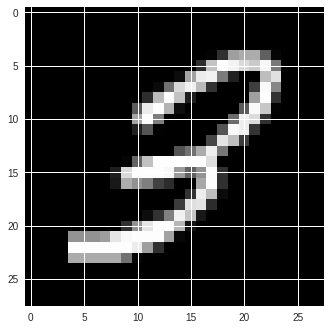

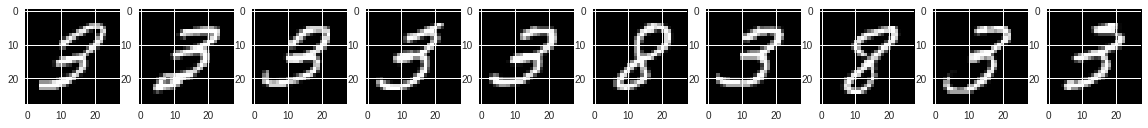

In [0]:
plt.imshow(test_sample.reshape(28,28), cmap='gray')

plt.figure(figsize=(20, n_results+1))

for i in range(n_results):
    ax = plt.subplot(1, n_results, i+1)
    plt.imshow(result_images[i].reshape(28, 28))
    plt.gray()

    
plt.show()

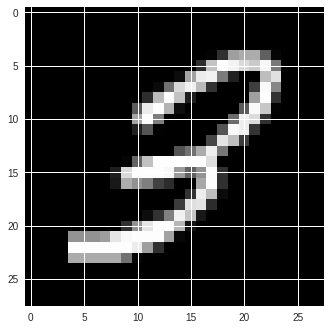

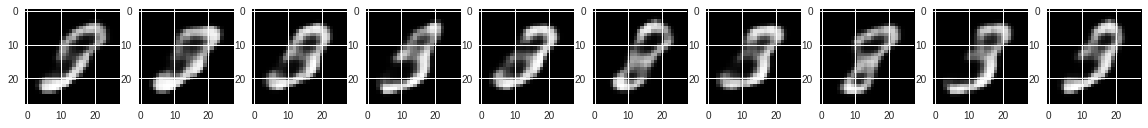

In [0]:
decoded_image = decoder.predict(encoded_search_set)

plt.imshow(test_sample.reshape(28,28), cmap='gray')

plt.figure(figsize=(20, n_results+1))

for i in range(n_results):
    ax = plt.subplot(1, n_results, i+1)
    plt.imshow(decoded_image[i].reshape(28, 28))
    plt.gray()

    
plt.show()

In [0]:
from scipy.stats import norm
from sklearn import manifold

# map latent space to 2-D
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(search_set)
print("tsne done fitting")


tsne done fitting


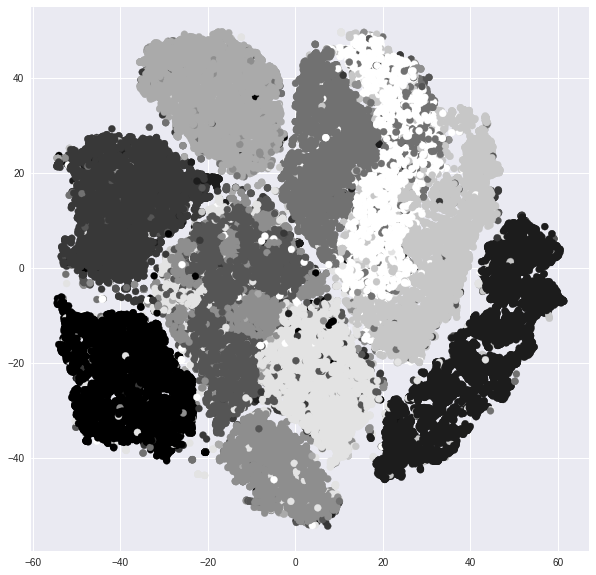

In [0]:
plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train)
plt.show()

So how does trained vs untrained compaere? 


In [0]:
untrained_ae, untrained_e, untrained_d = create_autoencoder()
untrained_search_set = untrained_ae.predict(x_train)

untrained_search_set = untrained_search_set.reshape(-1, shape_product); 

untrained_tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
untrained_X_tsne = untrained_tsne.fit_transform(untrained_search_set)

plt.figure(figsize=(10, 10))
plt.scatter(untrained_X_tsne[:, 0], untrained_X_tsne[:, 1], c=y_train)
plt.show()

(?, 4, 4, 8)
